---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [10]:
# Look at ll the columns in the dataset
def print_all(X, max_rows=5):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))


In [ ]:
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

# describe_categorical(X_train)
# print_all(X_train)

In [9]:
# Simple version that shows all of the variables
def plot_feature_imp(model, X):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(inplace=True)
    feature_importances.plot(kind="barh", figsize=(8, 6))
    plt.show()

In [4]:
# Get only the numeric variables by selecting only the variables that are not of "object" datatypes
# numeric_variables = list(X_train.dtypes[X_train.dtypes != "object"].index)
# X_train[numeric_variables].head()

1.0


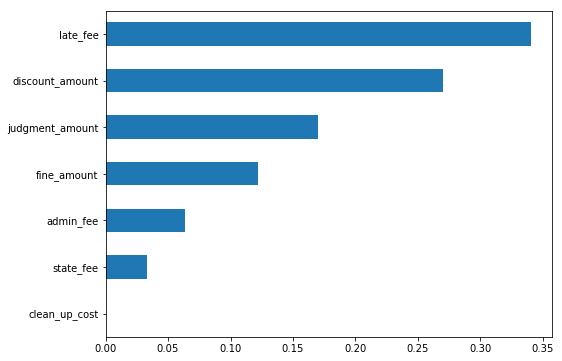

                  0
ticket_id          
284932     0.060585
285362     0.022219
285361     0.069030
285338     0.060585
285346     0.069030
285345     0.060585
285347     0.057488
285342     0.374568
285530     0.022219
284989     0.031300
285344     0.057488
285343     0.022219
285340     0.022219
285341     0.057488
285349     0.069030
285348     0.060585
284991     0.031300
285532     0.031300
285406     0.031300
285001     0.031300
285006     0.022219
285405     0.022219
285337     0.031300
285496     0.057488
285497     0.060585
285378     0.022219
285589     0.031300
285585     0.060585
285501     0.069030
285581     0.022219
...             ...
376367     0.038644
376366     0.036291
376362     0.036291
376363     0.060585
376365     0.038644
376364     0.036291
376228     0.036291
376265     0.036291
376286     0.307032
376320     0.036291
376314     0.036291
376327     0.307032
376385     0.307032
376435     0.474899
376370     0.307032
376434     0.057488
376459     0.069030


In [24]:
def blight_model():
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import roc_auc_score

    import pandas as pd
    import numpy as np
    # import matplotlib.pyplot as plt

    X_train = pd.read_csv('train.csv', encoding='latin1', low_memory=False)
    X_test = pd.read_csv('test.csv')
    addresses = pd.read_csv('addresses.csv')

    # Fill up the missing numeric values with mean
    X_train['fine_amount'].fillna(X_train.fine_amount.mean(), inplace=True)
    X_train['admin_fee'].fillna(X_train.admin_fee.mean(), inplace=True)
    X_train['state_fee'].fillna(X_train.state_fee.mean(), inplace=True)
    X_train['late_fee'].fillna(X_train.late_fee.mean(), inplace=True)
    X_train['discount_amount'].fillna(X_train.discount_amount.mean(), inplace=True)
    X_train['clean_up_cost'].fillna(X_train.clean_up_cost.mean(), inplace=True)
    X_train['judgment_amount'].fillna(X_train.judgment_amount.mean(), inplace=True)
    X_train['compliance'].fillna(0.0, inplace=True)

    # These two fields are not available in X_test, so we drop them 
    # from X_train as well
    X_train['payment_amount'].fillna(X_train.payment_amount.mean(), inplace=True)
    X_train['balance_due'].fillna(X_train.balance_due.mean(), inplace=True)

    X_test['fine_amount'].fillna(X_test.fine_amount.mean(), inplace=True)
    X_test['admin_fee'].fillna(X_test.admin_fee.mean(), inplace=True)
    X_test['state_fee'].fillna(X_test.state_fee.mean(), inplace=True)
    X_test['late_fee'].fillna(X_test.late_fee.mean(), inplace=True)
    X_test['discount_amount'].fillna(X_test.discount_amount.mean(), inplace=True)
    X_test['clean_up_cost'].fillna(X_test.clean_up_cost.mean(), inplace=True)
    X_test['judgment_amount'].fillna(X_test.judgment_amount.mean(), inplace=True)
    # X_test['payment_amount'].fillna(X_test.payment_amount.mean(), inplace=True)
    # X_test['balance_due'].fillna(X_test.balance_due.mean(), inplace=True)


    y_train = X_train.pop("compliance")
    
    
    # Drop the variables from X_train that won't be needed for this task
    X_train.drop(['ticket_id', 'payment_amount', 'balance_due', 'violation_street_number', 'violation_street_name', 'violation_zip_code', 'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'non_us_str_code', 'country', 'agency_name', 'inspector_name', 'violator_name', 'ticket_issued_date', 'hearing_date', 'violation_code', 'violation_description', 'disposition', 'payment_date', 'payment_status', 'collection_status', 'grafitti_status', 'compliance_detail'], axis=1, inplace=True)
    # X_train.set_index('ticket_id')
    
    
    # Drop the variables from X_test that won't be needed for this task
    ticket_ids = X_test['ticket_id']
    X_test.drop(['ticket_id', 'violation_street_number', 'violation_street_name', 'violation_zip_code', 'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'non_us_str_code', 'country', 'agency_name', 'inspector_name', 'violator_name', 'ticket_issued_date', 'hearing_date', 'violation_code', 'violation_description', 'disposition', 'grafitti_status'], axis=1, inplace=True)
    # X_test.set_index('ticket_id')
    
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier(n_estimators = 200, random_state=0)
    clf.fit(X_train, y_train)

    predict_proba = clf.predict_proba(X_test)[:, 1]

    y_predict = clf.predict(X_test)
    
    result_df = pd.DataFrame(data=predict_proba, index=ticket_ids)
    
    # print(predict_proba.shape)
    
    # print(roc_auc_score(y_predict, predict_proba))
    
    plot_feature_imp(clf, X_test)
    
    return result_df

print(blight_model())